<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Random_forest_Modular_Correct(Daily_New).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/anirbanghoshsbi/pandas-technical-indicators.git

Cloning into 'pandas-technical-indicators'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 202 (delta 105), reused 0 (delta 0), pack-reused 27
Receiving objects: 100% (202/202), 58.64 KiB | 5.33 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [ ]:
!pwd

/content/pandas-technical-indicators


In [ ]:
%cd pandas-technical-indicators

/content/pandas-technical-indicators/pandas-technical-indicators


In [ ]:
# Import libraries
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [ ]:
import technical_indicators as ta
import random_forest as rf
import confusionMatrix as cm
import easy_line_ploting as linplt

In [ ]:
tickr ='^NSEI'   #'^NSEI' #^NSEBANK  #^cnxit #^GSPC #^YHOH714

In [ ]:
df_old = pd.DataFrame()

In [ ]:
df_old = ta.download_from_yahoo(tickr,'2014-01-01','2020-05-01')

[*********************100%***********************]  1 of 1 downloaded


In [ ]:
df_old.shape

(1543, 5)

# INPUT

In [ ]:
# INPUT .........

#  ********************************* #

t=2
days_out=24


#  ********************************* #

In [ ]:
def get_supertrend(high, low, close, lookback, multiplier):
    
    # ATR
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(lookback).mean()
    
    # H/L AVG AND BASIC UPPER & LOWER BAND
    
    hl_avg = (high + low) / 2
    upper_band = (hl_avg + multiplier * atr).dropna()
    lower_band = (hl_avg - multiplier * atr).dropna()
    
    # FINAL UPPER BAND
    final_bands = pd.DataFrame(columns = ['upper', 'lower'])
    final_bands.iloc[:,0] = [x for x in upper_band - upper_band]
    final_bands.iloc[:,1] = final_bands.iloc[:,0]
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i,0] = 0
        else:
            if (upper_band[i] < final_bands.iloc[i-1,0]) | (close[i-1] > final_bands.iloc[i-1,0]):
                final_bands.iloc[i,0] = upper_band[i]
            else:
                final_bands.iloc[i,0] = final_bands.iloc[i-1,0]
    
    # FINAL LOWER BAND
    
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i, 1] = 0
        else:
            if (lower_band[i] > final_bands.iloc[i-1,1]) | (close[i-1] < final_bands.iloc[i-1,1]):
                final_bands.iloc[i,1] = lower_band[i]
            else:
                final_bands.iloc[i,1] = final_bands.iloc[i-1,1]
    
    # SUPERTREND
    
    supertrend = pd.DataFrame(columns = [f'supertrend_{lookback}'])
    supertrend.iloc[:,0] = [x for x in final_bands['upper'] - final_bands['upper']]
    
    for i in range(len(supertrend)):
        if i == 0:
            supertrend.iloc[i, 0] = 0
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] < final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] > final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] > final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] < final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
    
    supertrend = supertrend.set_index(upper_band.index)
    supertrend = supertrend.dropna()[1:]
    
    # ST UPTREND/DOWNTREND
    
    upt = []
    dt = []
    close = close.iloc[len(close) - len(supertrend):]

    for i in range(len(supertrend)):
        if close[i] > supertrend.iloc[i, 0]:
            upt.append(supertrend.iloc[i, 0])
            dt.append(np.nan)
        elif close[i] < supertrend.iloc[i, 0]:
            upt.append(np.nan)
            dt.append(supertrend.iloc[i, 0])
        else:
            upt.append(np.nan)
            dt.append(np.nan)
            
    st, upt, dt = pd.Series(supertrend.iloc[:, 0]), pd.Series(upt), pd.Series(dt)
    upt.index, dt.index = supertrend.index, supertrend.index
    
    return st, upt, dt

In [ ]:
def get_indicators(data ,days_out,t=1):
    data = ta.relative_strength_index(data,days_out)
    #data=ta.exponential_moving_average(data,10*t)
    #data=ta.exponential_moving_average(data,50*t)
    data=ta.momentum(data,7*t)
    data=ta.rate_of_change(data,7*t)
    data=ta.exponential_moving_average(data,7*t)
    
    #data=ta.exponential_moving_average(data , 13*t)
    #data=ta.exponential_moving_average(data ,26*t)
    data=ta.force_index(data ,days_out)
    data = ta.on_balance_volume(data , days_out)
    data = ta.standard_deviation(data , days_out)
    data = ta.stochastic_oscillator_d(data ,days_out)
    data = ta.stochastic_oscillator_k(data)
    data = ta.macd(data , 9 , 12)
    data = ta.ppsr(data)
    data = ta.trix(data,days_out)
    data = ta.vortex_indicator(data , days_out)
    data = ta.find_window_high_low(data,days_out)
    #data = ta.keltner_channel(data , 13)
    #data['change_in_price'] = data['Close'].diff()
    
    return data


# Check This For Weekly or Daily 

In [ ]:
############################ Comment or Uncomment Based on Daily or Weekly ##########

#df_old=df_old.resample('W').last()

In [ ]:
train=int(len(df_old)*.75)
df_train= df_old[:train]
df_test= df_old[train+50:]

In [ ]:
df_train.shape , df_test.shape

((1157, 5), (336, 5))

In [ ]:
df_train = get_indicators(df_train,days_out,1)
df_test= get_indicators(df_test,days_out,1)

In [ ]:
df_old.tail(2)

,Open,High,Low,Close,Volume
Date,,,,,
2020-04-29,9408.599609,9599.849609,9392.349609,9553.349609,653000
2020-04-30,9753.500000,9889.049805,9731.500000,9859.900391,931200


In [ ]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_train['Signal_Flag'] = df_train['Close'].transform(lambda x : np.sign(x.diff(days_out)))

df_train = df_train.dropna()


In [ ]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_test['Signal_Flag'] = df_test['Close'].transform(lambda x : np.sign(x.diff(days_out)))

df_test = df_test.dropna()

In [ ]:
X_train = df_train.drop(['Signal_Flag'],axis=1)
y_train = df_train['Signal_Flag']
X_test = df_test.drop(['Signal_Flag'],axis=1)
y_test = df_test['Signal_Flag']

In [ ]:
############## JUST REMOVE # TO COMPUTE THE BEST PARAMETERS #######################

#rf.best_param_rf(X_train , y_train , 100)

In [ ]:
'''
>>> 100 iterations
{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 37.9min finished
{'Best Score': 0.9169554134840112,
 'Best parameters': {'bootstrap': True,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 60,
  'max_features': None,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 7,
  'min_samples_split': 5,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 200,
  'n_jobs': None,
  'oob_score': False,
  'random_state': None,
  'verbose': 0,
  'warm_start': False}}
  
>>> for n_iter=300
{'Best Score': 0.9654412531082027,
 'Best parameters': {'bootstrap': False,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 10,
  'max_features': None,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 16,
  'min_samples_split': 5,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 1800,
  'n_jobs': None,
  'oob_score': False,
  'random_state': None,
  'verbose': 0,
  'warm_start': False}}
  '''

"\n100 iterations\n{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}\nFitting 3 folds for each of 100 candidates, totalling 300 fits\n[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.\n[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min\n[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 19.3min\n[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 37.9min finished\n{'Best Score': 0.9169554134840112,\n 'Best parameters': {'bootstrap': True,\n  'ccp_alpha': 0.0,\n  'class_weight': None,\n  'criterion': 'gini',\n  'max_depth': 60,\n  'max_features': None,\n  'max_leaf_nodes': None,\n  'max_samples': None,\n  'min_impurity_decrease': 0.0,\n  'min_impurity_split': None,\n  'min_samples_leaf': 7,\n  'min_sa

In [ ]:
# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 200,max_depth=80,min_samples_leaf=2,max_features='auto', min_samples_split=2, criterion = "gini", bootstrap=True,random_state = 42)
# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)


In [ ]:
# Print the Accuracy of our Model.
print('Correct Prediction RForest (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction RForest (%):  93.23308270676691


Accuracy: 93.23308270676691
Percision: 90.38461538461539
Recall: 97.91666666666666
Specificity: 87.70491803278688


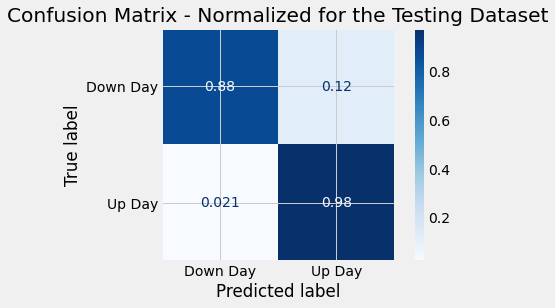

In [ ]:
cm.confus_matrix(y_test,y_pred,rand_frst_clf,X_test,y_test,plot=True )

#cm.confus_matrix(actual_results , predictions,model ,<test data ( or new_data for prediction except target VAR)>, <actaul Target VAR> , <plot=True>)

In [ ]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp*100
feats=X_train.columns

# Logistic Regression

In [ ]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [ ]:
LogReg = LogisticRegression()
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
LogReg.fit(X_train, y_train)
y_predL = LogReg.predict(X_test)

In [ ]:
# Print the Accuracy of our Model.
print('Correct Prediction Logistic Regression (%): ', accuracy_score(y_test, LogReg.predict(X_test), normalize = True) * 100.0)

Correct Prediction Logistic Regression (%):  85.71428571428571


Accuracy: 85.71428571428571
Percision: 85.8108108108108
Recall: 88.19444444444444
Specificity: 82.78688524590164


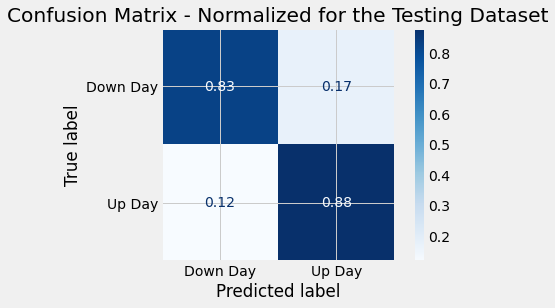

In [ ]:
cm.confus_matrix(y_test,y_predL,LogReg,X_test,y_test,plot=True )

# Support Vector Classifier

In [ ]:
from sklearn.svm import SVC
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
svc_classifier = SVC(kernel = 'linear', random_state = 0)
svc_classifier.fit(X_train, y_train)
y_predS = svc_classifier.predict(X_test)

In [ ]:
# Print the Accuracy of our Model.
print('Correct Prediction Logistic Regression (%): ', accuracy_score(y_test, svc_classifier.predict(X_test), normalize = True) * 100.0)

Correct Prediction Logistic Regression (%):  87.21804511278195


Accuracy: 87.21804511278195
Percision: 87.67123287671232
Recall: 88.88888888888889
Specificity: 85.24590163934425


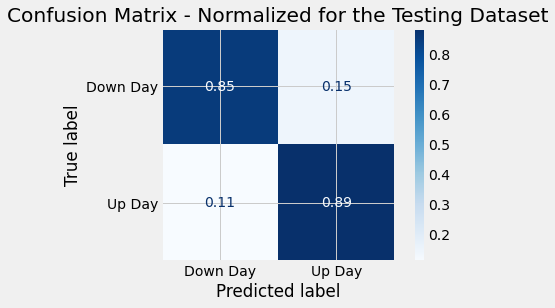

In [ ]:
cm.confus_matrix(y_test,y_predS,svc_classifier,X_test,y_test,plot=True )

# XGBoost Classifier

In [ ]:
import xgboost as xgb

In [ ]:
'''
param_test1 = {
 'max_depth':range(3,6,2),'learning_rate':[0.001,0.01,0.1,0.05],
 'min_child_weight':range(1,4,2),'reg_alpha':[0, 0.001, 0.005, 0.01],'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,85,5)],'gamma':[i/10.0 for i in range(0,2)],
 'n_estimators': [10,50,100,200,300]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=1e-5,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,verbose=10,cv=5)
 
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_
'''

"\nparam_test1 = {\n 'max_depth':range(3,6,2),'learning_rate':[0.001,0.01,0.1,0.05],\n 'min_child_weight':range(1,4,2),'reg_alpha':[0, 0.001, 0.005, 0.01],'subsample':[i/100.0 for i in range(75,90,5)],\n 'colsample_bytree':[i/100.0 for i in range(75,85,5)],'gamma':[i/10.0 for i in range(0,2)],\n 'n_estimators': [10,50,100,200,300]\n}\ngsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,\n min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=1e-5,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \n param_grid = param_test1, scoring='roc_auc',n_jobs=4,verbose=10,cv=5)\n \ngsearch1.fit(X_train,y_train)\ngsearch1.best_params_, gsearch1.best_score_\n"

In [ ]:
xgb_classifier = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_classifier.fit(X_train, y_train)
y_predX = xgb_classifier.predict(X_test)
print("Accuracy for XGBoost Model: %.2f" % (accuracy_score(y_test, y_predX) * 100))

Accuracy for XGBoost Model: 93.61


Accuracy: 93.60902255639097
Percision: 91.50326797385621
Recall: 97.22222222222221
Specificity: 89.34426229508196


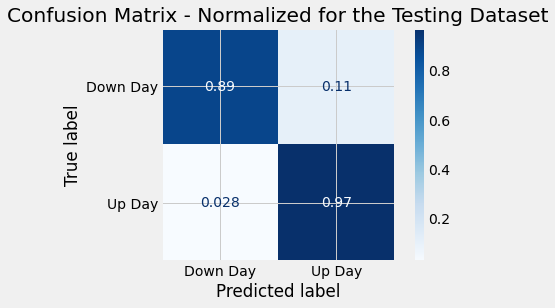

In [ ]:
cm.confus_matrix(y_test,y_predX,xgb_classifier,X_test,y_test,plot=True )

In [ ]:
feature_imp_XGB = pd.Series(xgb_classifier.feature_importances_, index=feats).sort_values(ascending=False)
feature_imp_XGB*100

Vortex_24                   43.405685
MACDsign_9_12                8.046811
OBV_24                       4.067753
MACD_9_12                    4.009275
SO%k                         3.090331
RSI_24                       3.000812
SO%d_24                      2.761683
R1                           2.641119
MACDdiff_9_12                2.262261
Momentum_7                   2.238334
S1                           1.927600
Force_24                     1.881500
Open                         1.869245
R2                           1.854997
ROC_7                        1.709874
Win_Low                      1.676100
Volume                       1.548828
R3                           1.496427
S3                           1.444826
STD_24                       1.410837
Trix_24                      1.357748
Close                        1.338818
Win_High                     1.301338
Low                          1.116681
High                         0.930854
S2                           0.659554
EMA_7       

In [ ]:
features = {'Random Forest' : feature_imp,'XGBoost': feature_imp_XGB}
feats=pd.DataFrame(features)

In [ ]:
feats.sort_values(by=['XGBoost'],ascending=False)

,Random Forest,XGBoost
Vortex_24,0.282119,0.434057
MACDsign_9_12,0.155080,0.080468
OBV_24,0.149422,0.040678
MACD_9_12,0.112999,0.040093
SO%k,0.007141,0.030903
RSI_24,0.085876,0.030008
SO%d_24,0.034063,0.027617
R1,0.003801,0.026411
MACDdiff_9_12,0.010829,0.022623
Momentum_7,0.018841,0.022383


# Make Actual Prediction

In [ ]:
df = pd.DataFrame()

In [ ]:
df = ta.download_from_yahoo(tickr,'2020-10-01')

[*********************100%***********************]  1 of 1 downloaded


In [ ]:
df.tail(3)

,Open,High,Low,Close,Volume
Date,,,,,
2021-06-23,15862.799805,15862.950195,15673.950195,15686.950195,287500
2021-06-24,15737.299805,15821.400391,15702.700195,15790.450195,316700
2021-06-25,15839.349609,15844.450195,15772.299805,15838.700195,0


# Check This For Weekly or Daily

In [ ]:
####################### Comment or Uncomment Based on Weekly or Daily ##################
#df=df.resample('W').last()

In [ ]:
df = get_indicators(df,days_out,1)
#df= impulse(df)

In [ ]:
df.tail(2)

,Open,High,Low,Close,Volume,RSI_24,Momentum_7,ROC_7,EMA_7,Force_24,OBV_24,STD_24,SO%d_24,SO%k,MACD_9_12,MACDsign_9_12,MACDdiff_9_12,PP,R1,S1,R2,S2,R3,S3,Trix_24,Vortex_24,Win_High,Win_Low,Signals_from_Window_HiLo
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-24,15737.299805,15821.400391,15702.700195,15790.450195,316700,0.451275,-78.799805,0.001452,15744.469024,-1.576015e+08,109337.500000,192.800079,0.554608,0.739257,20.565304,34.917997,-14.352693,15771.516927,15840.333659,15721.633463,15890.217123,15652.816731,15959.033855,15602.933267,0.001533,0.346546,15901.599609,14985.849609,0.0
2021-06-25,15839.349609,15844.450195,15772.299805,15838.700195,0,0.464397,71.150390,0.009387,15768.026817,-3.716518e+08,85179.166667,174.171502,0.583864,0.920305,22.105760,32.355550,-10.249790,15818.483398,15864.666992,15792.516602,15890.633788,15746.333008,15936.817382,15720.366212,0.001539,0.313295,15901.599609,15145.450195,0.0


In [ ]:
df_old.head(2)

,Open,High,Low,Close,Volume
Date,,,,,
2014-01-02,6301.250000,6358.299805,6211.299805,6221.149902,158100
2014-01-03,6194.549805,6221.700195,6171.250000,6211.149902,139000


In [ ]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df['Signal_Flag'] = df['Close'].transform(lambda x : np.sign(x.diff(days_out)))

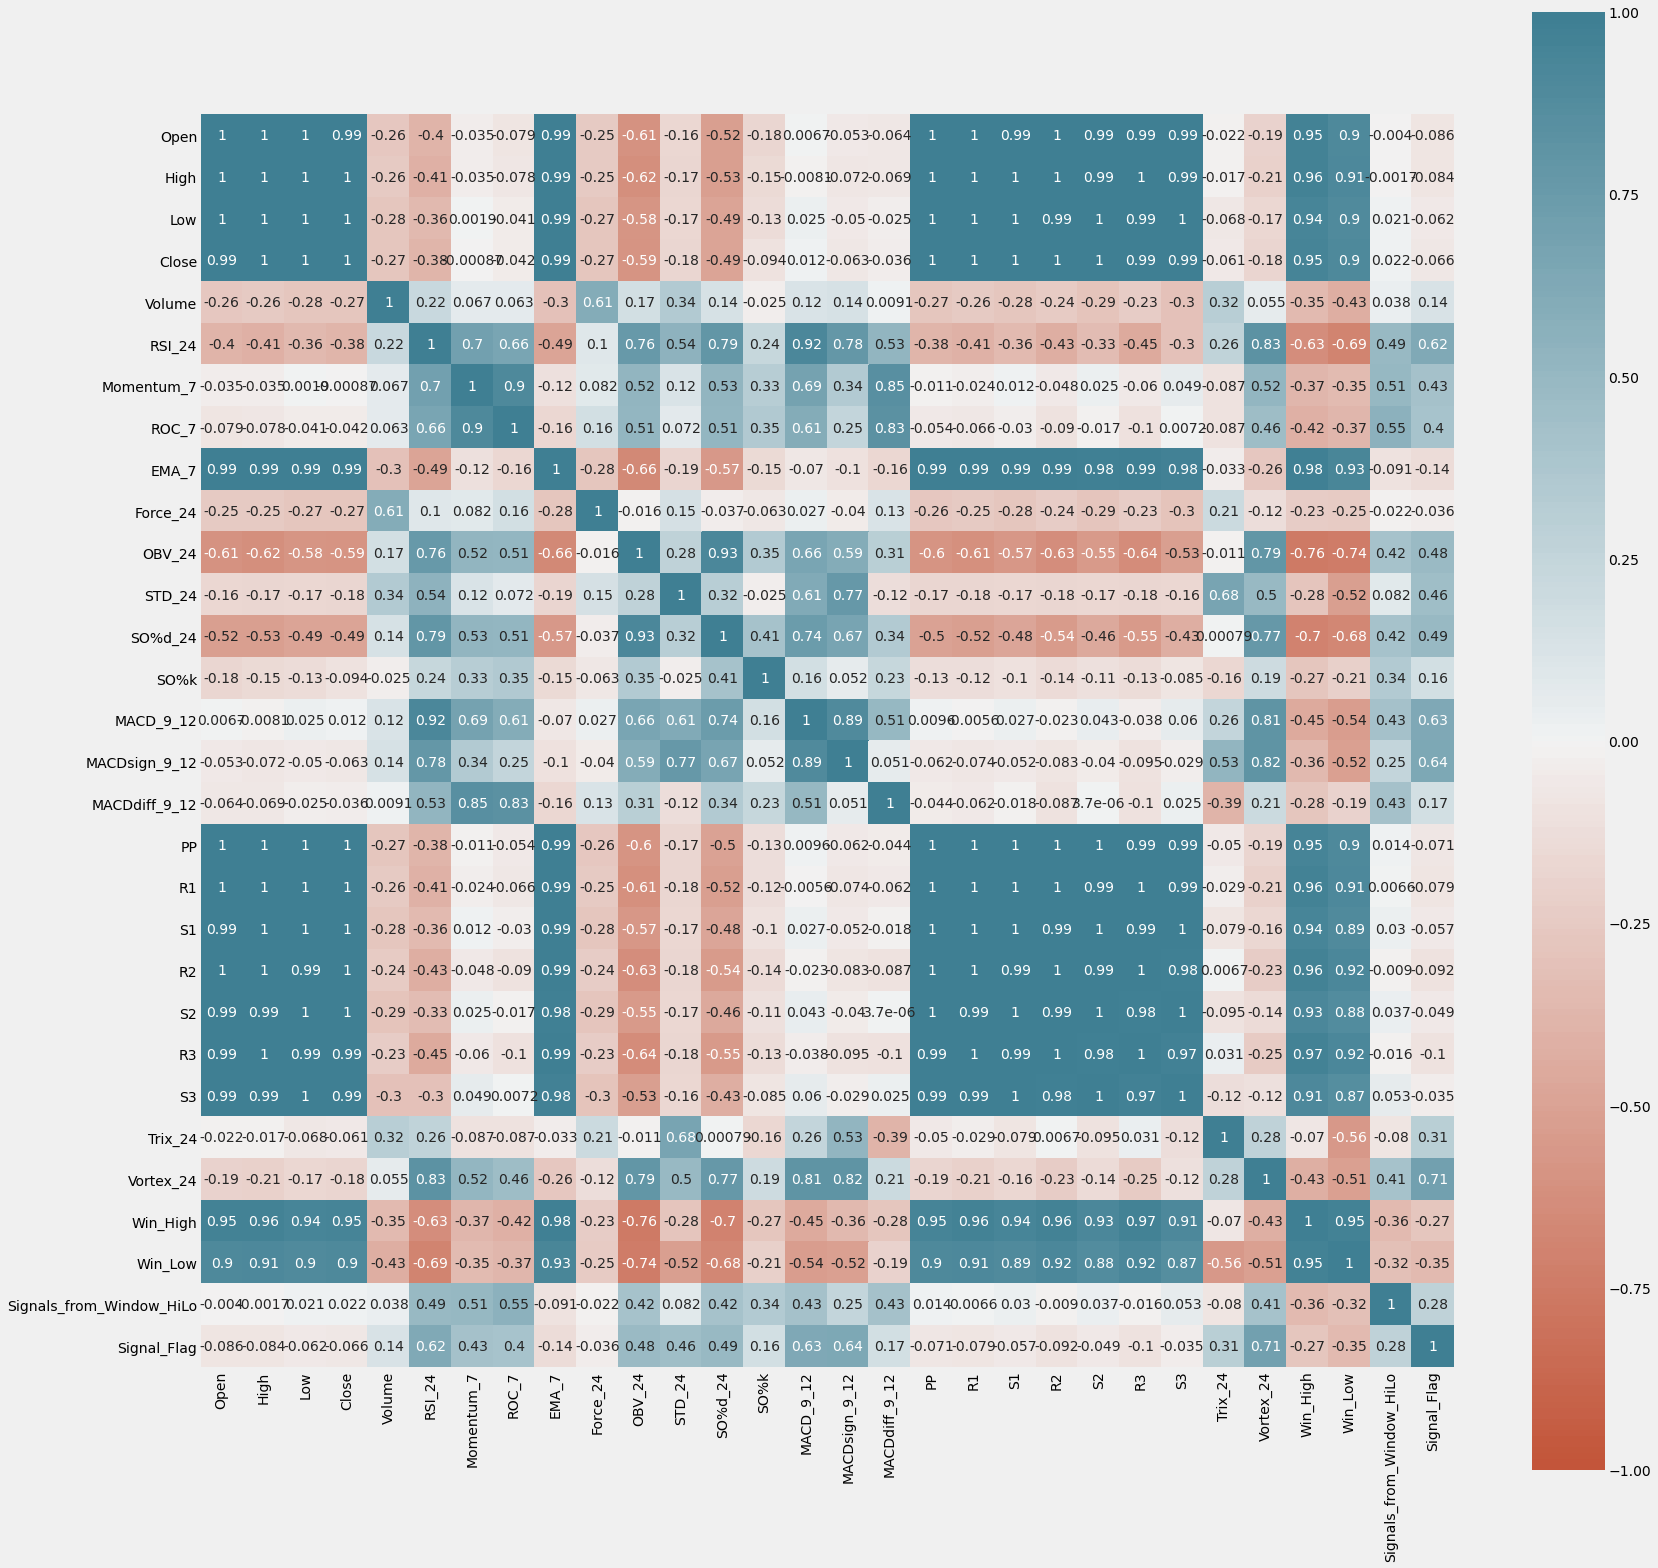

In [ ]:
ta.correlation_map(df,25)

In [ ]:
df.shape

(180, 30)

In [ ]:
df=df.dropna()

In [ ]:
df.shape

(110, 30)

In [ ]:
new_data = df.drop(['Signal_Flag'],axis=1)
actuals= df['Signal_Flag']


# Make Predictions Using Random Forest

In [ ]:
model='random_forest'

In [ ]:
preds=rf.make_preds(new_data ,rand_frst_clf,model,df)

In [ ]:
print("days_out : ",days_out)

days_out :  24


In [ ]:
preds.head(2)

,predsrandom_forest
Date,
2021-01-14,1.0
2021-01-15,1.0


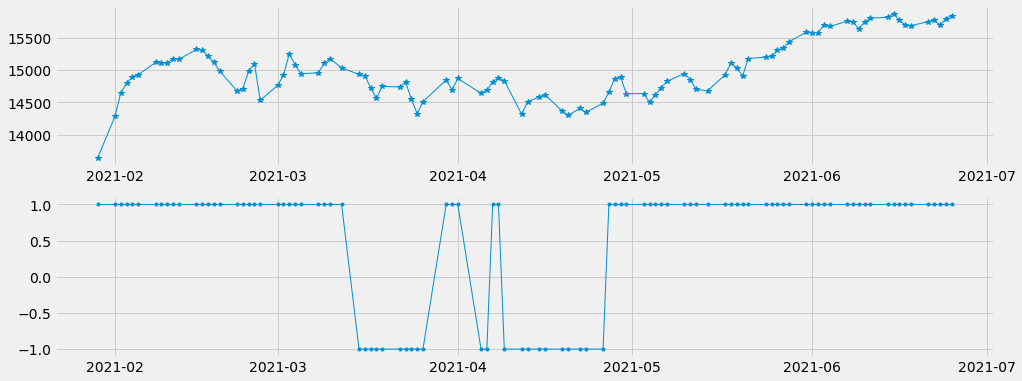

In [ ]:
linplt.lineplot(2,15,6,df,preds['predsrandom_forest'], no_of_datapoints=100) # no_of_datapoints=100

In [ ]:
pred = pd.DataFrame(rf.make_preds(new_data , rand_frst_clf, model,df))

In [ ]:
pred.head(2)

,predsrandom_forest
Date,
2021-01-14,1.0
2021-01-15,1.0


In [ ]:
pred = pd.concat([pred ,df.Close],axis=1)
#pred.columns=['Date','preds','Close']
#pred= pred.set_index('Date')

In [ ]:
l= len(pred)

In [ ]:
#fig, ax = plt.subplots(1,1,figsize=(20,7))
#Identifying the buy/sell zone
pred['Buy_ind'] = np.where((pred['predsrandom_forest']==1), 1, 0)
pred['Sell_ind'] = np.where((pred['predsrandom_forest']==-1), 0, 1)

In [ ]:
pred=pred.reset_index()

# Make Prediction Using XGBoost

In [ ]:
model='_XGB'

In [ ]:
predX=rf.make_preds(new_data.values ,xgb_classifier,model,df)

In [ ]:
predX= pd.concat([predX ,df.Close],axis=1)

In [ ]:
predX.head(2)

,preds_XGB,Close
Date,,
2021-01-14,1.0,14595.599609
2021-01-15,1.0,14433.700195


In [ ]:
#Identifying the buy/sell zone
predX['Buy_ind_XGB'] = np.where((predX['preds_XGB']==1), 1, 0)
predX['Sell_ind_XGB'] = np.where((predX['preds_XGB']==-1), 0, 1)

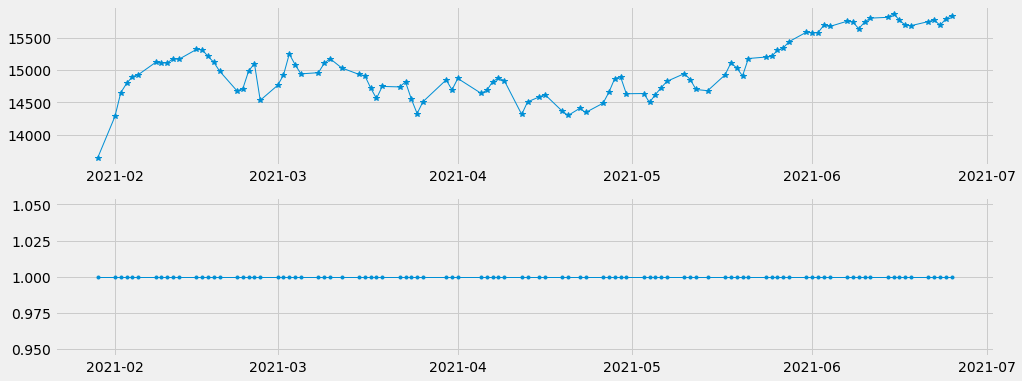

In [ ]:
linplt.lineplot(2,15,6,df,predX['preds_XGB'], no_of_datapoints=100) # no_of_datapoints=100

In [ ]:
predX=predX.reset_index()

# Make Prediction Using Logistics Regression

In [ ]:
model='_Logistic_Regression'

In [ ]:
preds_logreg=pd.DataFrame(rf.make_preds(new_data , LogReg,model, df))

In [ ]:
preds_logreg.head(2)

,preds_Logistic_Regression
Date,
2021-01-14,-1.0
2021-01-15,-1.0


In [ ]:
predL = pd.concat([preds_logreg ,df.Close],axis=1)

In [ ]:
predL=predL.reset_index()

In [ ]:
#Identifying the buy/sell zone
predL['Buy_ind_Logreg'] = np.where((predL['preds_Logistic_Regression']==1), 1, 0)
predL['Sell_ind_Logreg'] = np.where((predL['preds_Logistic_Regression']==-1), 0, 1)

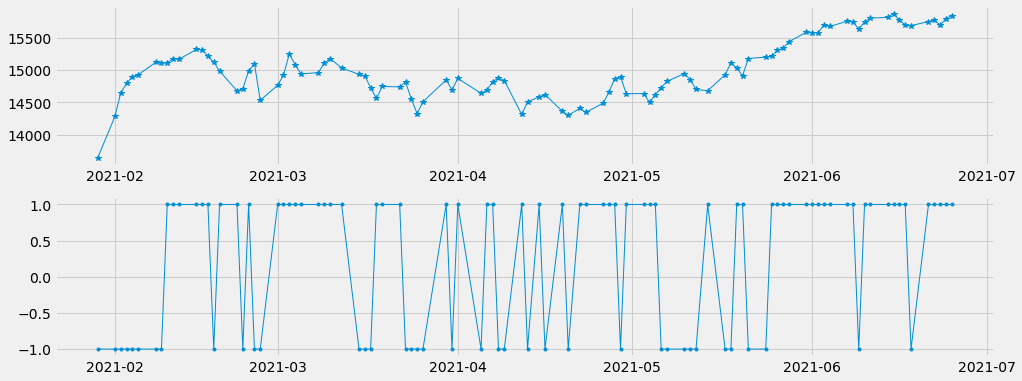

In [ ]:
linplt.lineplot(2,15,6,df,preds_logreg['preds_Logistic_Regression'], no_of_datapoints=100) # no_of_datapoints=100

# Make Predictions using Support Vector Classifier

In [ ]:
model='_SVC'

In [ ]:
preds_svc=pd.DataFrame(rf.make_preds(new_data ,svc_classifier,model, df))

In [ ]:
predS = pd.concat([preds_svc,df.Close],axis=1)

In [ ]:
predS=predS.reset_index()

In [ ]:
#Identifying the buy/sell zone
predS['Buy_ind_SVC'] = np.where((predS['preds_SVC']==1), 1, 0)
predS['Sell_ind_SVC'] = np.where((predS['preds_SVC']==-1), 0, 1)

# PREDICTIONS

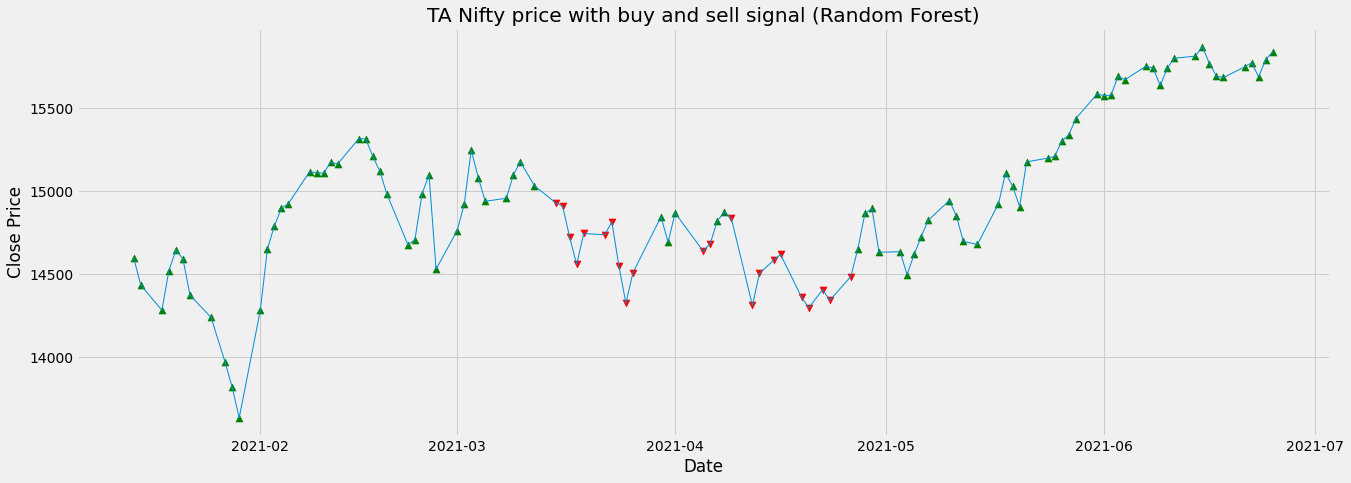

In [ ]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(pred.loc[pred['Buy_ind'] ==1 , 'Date'].values,pred.loc[pred['Buy_ind'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(pred.loc[pred['Sell_ind'] ==0 , 'Date'].values,pred.loc[pred['Sell_ind'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Random Forest)') 

plt.savefig('a.png')
plt.show();

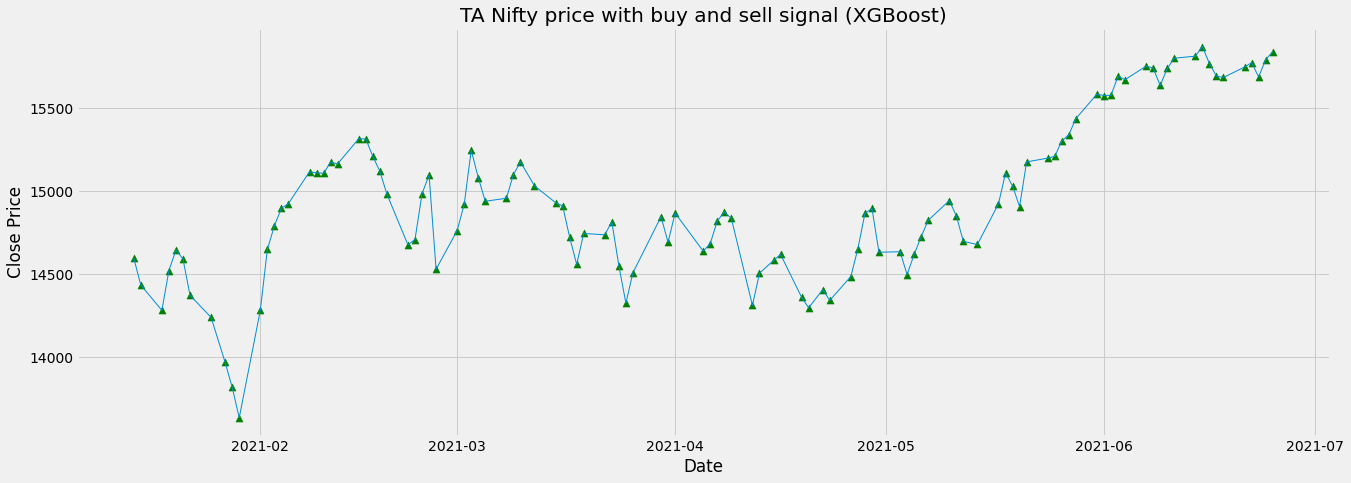

In [ ]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(predX.loc[predX['Buy_ind_XGB'] ==1 , 'Date'].values,predX.loc[predX['Buy_ind_XGB'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predX.loc[predX['Sell_ind_XGB'] ==0 , 'Date'].values,predX.loc[predX['Sell_ind_XGB'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (XGBoost)') 

plt.savefig('a.png')
plt.show();

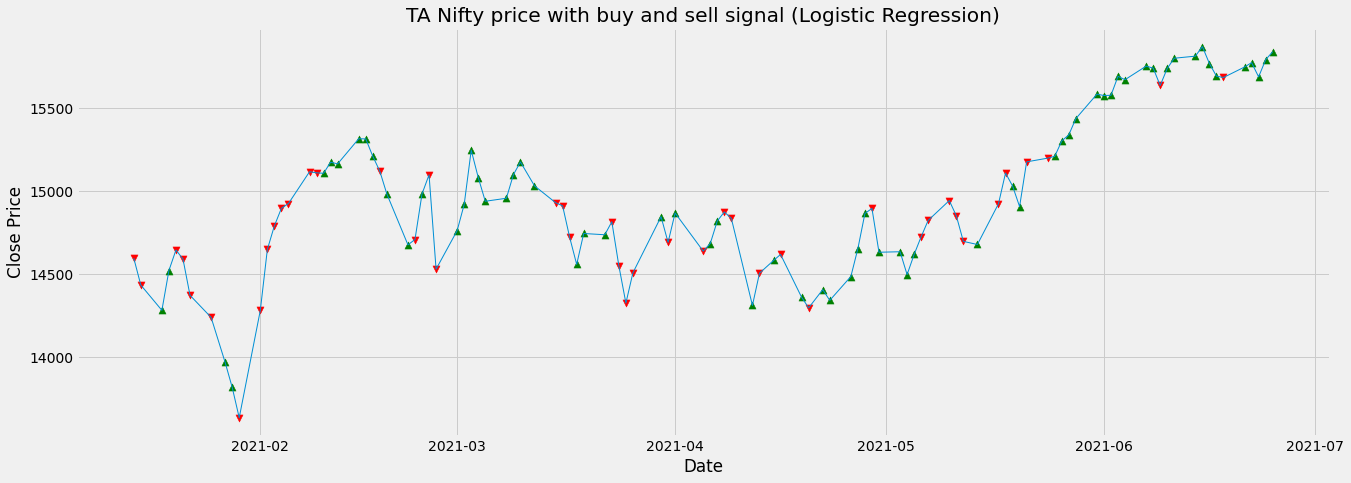

In [ ]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(predL.loc[predL['Buy_ind_Logreg'] ==1 , 'Date'].values,predL.loc[predL['Buy_ind_Logreg'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predL.loc[predL['Sell_ind_Logreg'] ==0 , 'Date'].values,predL.loc[predL['Sell_ind_Logreg'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Logistic Regression)') 

plt.savefig('a.png')
plt.show();

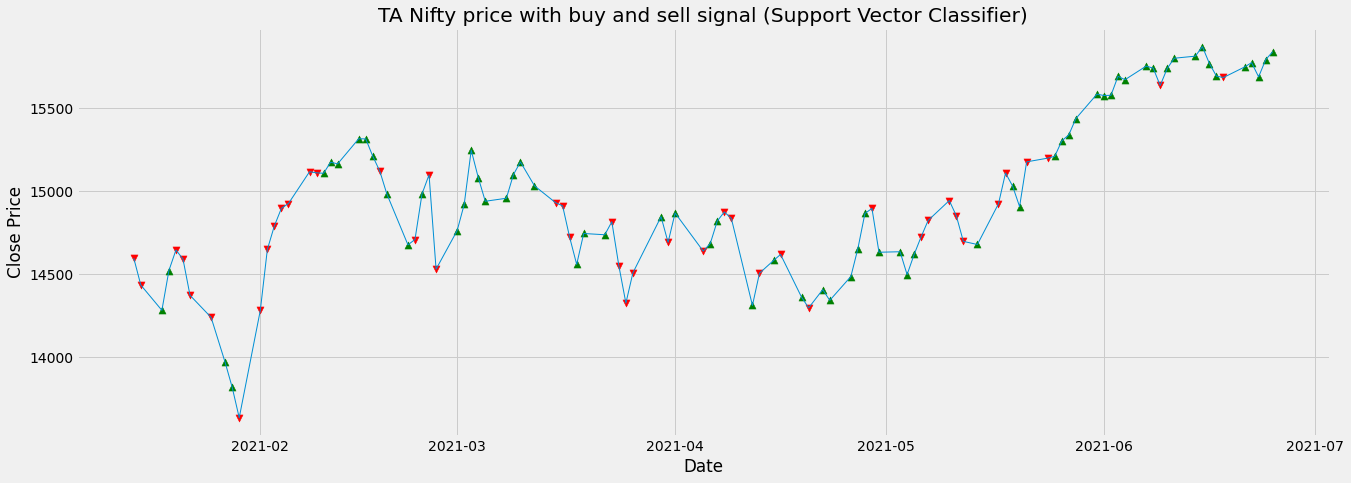

In [ ]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(predS.loc[predS['Buy_ind_SVC'] ==1 , 'Date'].values,predS.loc[predS['Buy_ind_SVC'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predS.loc[predS['Sell_ind_SVC'] ==0 , 'Date'].values,predS.loc[predS['Sell_ind_SVC'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Support Vector Classifier)') 

plt.savefig('a.png')
plt.show();

In [ ]:
pred['ensemble'] = predX['preds_XGB']*1+pred['predsrandom_forest']*0.5+predL['preds_Logistic_Regression']*0.5+predS['preds_SVC']*0.5

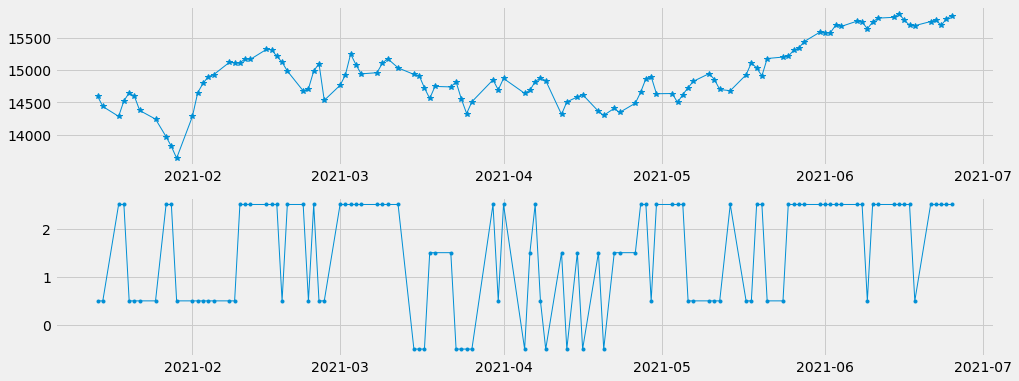

In [ ]:
linplt.lineplot(2,15,6,df,pred['ensemble'], no_of_datapoints=450) # no_of_datapoints=100

In [ ]:
pred['Signal_from_close']=np.where((pred.Close>pred.Close.shift(1)),1,0)

In [ ]:
#Identifying the buy/sell zone
pred['Buy_ensemble'] = np.where((pred['ensemble']>=0.5), 1, 0)

pred['Sell_ensemble'] = np.where((pred['ensemble']<0), 0, 1)
#pred['Neutral'] = np.where((pred['ensemble']==-0.5),0,1)
pred['signal4theday']= np.where((pred['ensemble']>=0),1,0)

In [ ]:
pred['signalF']= np.where((pred['signal4theday']>0) & (pred['Signal_from_close']>0),1,-1)

In [ ]:
pred[['signal4theday','Signal_from_close','signalF','Close']].tail(5)

,signal4theday,Signal_from_close,signalF,Close
105,1,1,1,15746.500000
106,1,1,1,15772.750000
107,1,0,-1,15686.950195
108,1,1,1,15790.450195
109,1,1,1,15838.700195


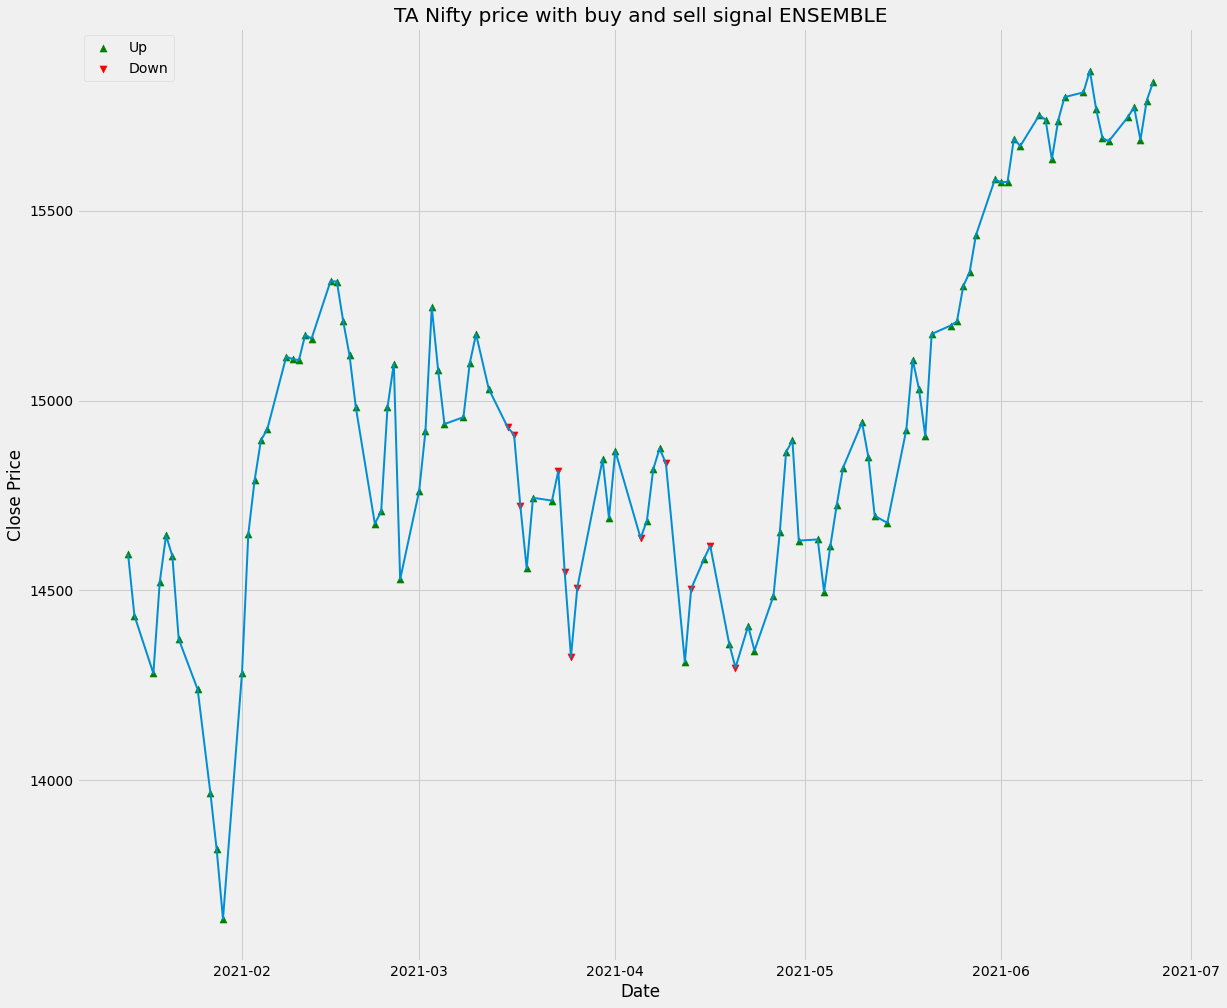

In [ ]:
plt.figure(figsize=(18,16))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=2)
plt.scatter(pred.loc[pred['Buy_ensemble'] ==1 , 'Date'].values,pred.loc[pred['Buy_ensemble'] ==1, 'Close'].values, label='Up', color='green', s=50, marker="^")
plt.scatter(pred.loc[pred['Sell_ensemble'] ==0 , 'Date'].values,pred.loc[pred['Sell_ensemble'] ==0, 'Close'].values, label='Down', color='red', s=50, marker="v")
#plt.scatter(pred.loc[pred['Neutral'] ==0 , 'Date'].values,pred.loc[pred['Neutral'] ==0, 'Close'].values, label='skitscat', color='blue', s=50, marker="*")
#plt.plot(df.index,df['EMA_50'].values[-l:],label='EMA 50')
#plt.plot(df.index,df['EMA_26'].values[-l:], label='EMA 26')

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price') 
plt.legend(loc='upper left') 
plt.title('TA Nifty price with buy and sell signal ENSEMBLE') 
plt.show();

Accuracy: 93.63636363636364
Percision: 93.18181818181817
Recall: 98.79518072289156
Specificity: 77.77777777777779


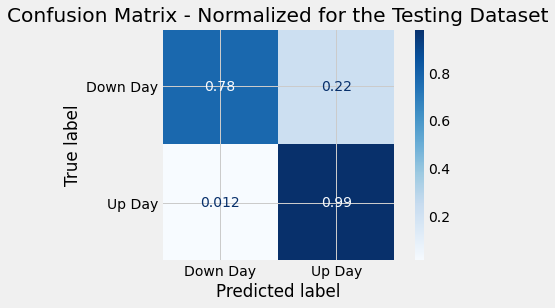

In [ ]:
cm.confus_matrix(df.Signal_Flag,preds,rand_frst_clf,new_data,actuals,plot=True )


Accuracy: 93.23308270676691
Percision: 90.38461538461539
Recall: 97.91666666666666
Specificity: 87.70491803278688


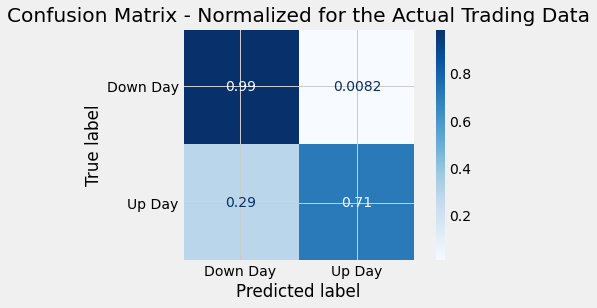

In [ ]:
cm.confus_matrix(y_test,y_pred,rand_frst_clf,X_test,y_test,plot=True, test=False)


In [ ]:
# saving the dataframe
pred.to_csv('/content/rf_TA.csv')

In [ ]:
pred.head(1)

,Date,predsrandom_forest,Close,Buy_ind,Sell_ind,ensemble,Signal_from_close,Buy_ensemble,Sell_ensemble,signal4theday,signalF
0,2021-01-14,1.0,14595.599609,1,1,0.5,0,1,1,1,-1


In [ ]:
pred.set_index('Date',inplace=True)

In [ ]:
pred.tail(2)

,predsrandom_forest,Close,Buy_ind,Sell_ind,ensemble,Signal_from_close,Buy_ensemble,Sell_ensemble,signal4theday,signalF
Date,,,,,,,,,,
2021-06-24,1.0,15790.450195,1,1,2.5,1,1,1,1,1
2021-06-25,1.0,15838.700195,1,1,2.5,1,1,1,1,1


In [ ]:
pred['actual']=np.where(pred.Close>pred.Close.shift(1),1,0)
pred['dummy']= np.where(pred.signal4theday==0,0,1)
pred['dummyS']=pred['dummy'].shift(1)
pred=pred.dropna()

In [ ]:
pred.signalF.value_counts()

 1    56
-1    53
Name: signalF, dtype: int64

In [ ]:
pred.dummyS.value_counts()

1.0    97
0.0    12
Name: dummyS, dtype: int64

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(pred.actual, pred.dummyS)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(pred.actual, pred.dummyS)

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
f1score= 2*recall*percision/(percision+recall)
print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {}'.format(float(f1score)))
print('Average Precision : {}'.format(float(average_precision)))

Accuracy: 0.5688073394495413
Percision: 0.5670103092783505
Recall: 0.9166666666666666
Specificity: 0.14285714285714285
F1-Score: 0.7006369426751591
Average Precision : 0.5656310098048488


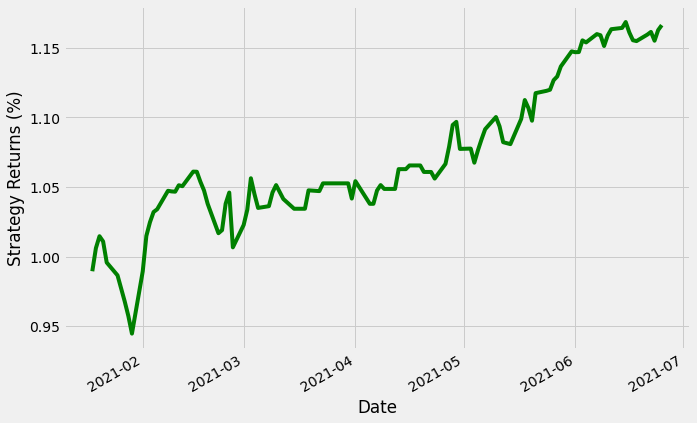

In [ ]:
# Calculate daily returns
pred['Return'] = pred.Close.pct_change()

# Calculate strategy returns
pred['Strategy_Return'] = pred.Return * pred.dummy.shift(1)

# Calculate geometric returns
geometric_returns = (pred.Strategy_Return+1).cumprod()

# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()

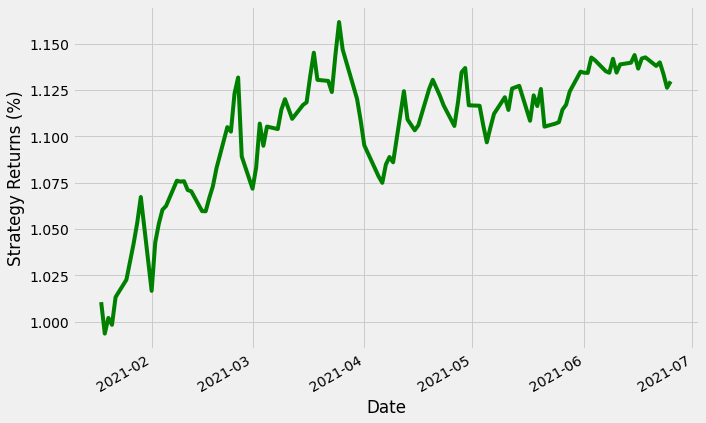

In [ ]:
# Calculate daily returns
pred['Return'] = pred.Close.pct_change()

# Calculate strategy returns
pred['Strategy_F'] = pred.Return * pred.signalF.shift(1)

# Calculate geometric returns
geometric_returns = (pred.Strategy_F+1).cumprod()

# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()